# Generator classes

A generator class is a more complex class to generate synthesis objects. It has an `.implement()` method returning a `@blackbox` entity which in turn is instanced by the synthesizer. Unlike a `@blackbox` top level block with signal interface, it is not instanced as a hierarchical module but created 'inline'. The actual interface is then a `SynthesisMapper` object with one `.q` boolean output. Only outputs types supported by the `SynthesisMappper` can be assigned to.

When a new kind of object inference from source code is desired, one would derive a custom class inheriting from the `myhdl.GeneratorClass` in order to be internally recognized.

Application scenarios:

* [Unary reduction operators](#Unary-reduction-operators)
* [Bit fields](#Bit-fields) Instructions and bitfield definitions

## Unary reduction operators

An often occuring issue is the boolean reduction operation on a bit vector as corresponding to the verilog unary operator expression `| v`.

The following class implements this for yosys synthesis.

In [1]:
from pyosys import libyosys as ys
from myhdl.conversion import yshelper
import operator
from myhdl import *

class Reduce(GeneratorClass):
    __name__ = "GeneratorClass reducer"

    count = 0
    _boolopmap = {
        operator.and_ : ys.Module.addReduceAnd,
        operator.or_  : ys.Module.addReduceOr,
        operator.xor  : ys.Module.addReduceXor,
    }

    def __init__(self, op):
        self.op = op
        self.func = self._boolopmap[op]
        print("Chose op", op)
    
    def implement(self, node, a):
        """This implementation function is mandatory for a GeneratorClass
        object. For yosys, it creates logic 'inline' to infer the slicing
        behaviour."""
        
        @blackbox
        def reduce(val):
            """Reducer logic"""
            @inference(yshelper.yosys)
            def implementation(module, sm):
                sm.q = module.addSignal(None, 1)
                identifier = yshelper.yosys.new_id(node, "reduce%d" % self.count)
                self.count += 1
                self.func(module.module, identifier, val, sm.q)

            return implementation
        
        return reduce(a)
    
    def __call__(self, v):
        "Implements the functionality for simulation"
        val = False
        for i in range(len(v)):
            val = self.op(val, v[i])
        return val

### Test bench

We create a `ReduceXor` operator and run it through a test bench:

In [2]:
ReduceXor = Reduce(operator.xor)

@block
def test_reduce():
    a, b = [ Signal(intbv(0xaa55)[16:]) for _ in range(2) ]
    
    r = Signal(bool())
    
    @instance
    def stimulate():
        a.next = 0xaa55
        yield delay(2)
        a.next = 0x55ab
        yield delay(2)
        a.next = 0xaaaa
        yield delay(2)
        a.next = 0xaaa7
        yield delay(2)
        a.next = 0xaa25
        yield delay(2)
        a.next = 0x0
        yield delay(2)
        print('DONE')
        raise StopSimulation
  
    @always_comb
    def worker():
        b.next = a
        r.next = ReduceXor(a)
        
    @always(a)
    def debug():
        if __debug__:
            print("a: %04x r: %s" % (b, r))
        
    
    return instances()

Chose op <built-in function xor>


Run test bench for a few cycles:

In [3]:
t = test_reduce()
t.run_sim()
t.quit_sim()

a: aa55 r: False
a: 55ab r: True
a: aaaa r: False
a: aaa7 r: True
a: aa25 r: True
DONE


Synthesize and create RTL view:

In [4]:
s = test_reduce()
d = yshelper.Design("reduce")
s.convert("yosys_module", d)

ANALYZE: Custom implementation method
CREATE Module: 'test_reduce'
Adding module with name: test_reduce
CONVERT_RTL tree >>>>>> 'TEST_REDUCE_STIMULATE' 
CALL 	visit_Yield()
CALL 	visit_Yield()
CALL 	visit_Yield()
CALL 	visit_Yield()
CALL 	visit_Yield()
CALL 	visit_Yield()
IGNORED FUNCTION: <ipython-input-2-a67f527ebdf1>:23 <built-in function print>
CONVERT_RTL tree >>>>>> 'TEST_REDUCE_WORKER' 
CUSTOM_GENERATOR: <ipython-input-2-a67f527ebdf1>:29 GeneratorClass reducer
SYNTHESIS: Wrapping for inference: yosys()
SYNTHESIS: Inferring implementation for module '\test_reduce'
CONVERT_RTL tree >>>>>> 'TEST_REDUCE_DEBUG' 
DONE instancing submodules


Generating RTL image...
Display...


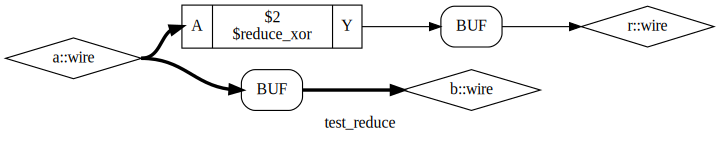

In [5]:
from ys_aux import to_svg
display(to_svg(d))

## Bit fields

To deal with bit fields and values, we use a specific `Bitfield` class to construct values.
It contains `lsb` and `msb` specifications and a value.
Unlike a python slice, the `lsb` and `msb` specifications are **inclusive**. When construction an instruction word, the `Bitfield` instances can be logically combined.

When decoding, they can be used as a function, passing a `value` to be sliced. The return value is either `True` or `False`, depending on a value match of the bit field in the `value`.

In [6]:
import operator

from myhdl.conversion.yshelper import Implementation, ConstSignal, NEW_ID


    
# These operators are supported:
IMPLEMENT_OPS = {
        '__add__': operator.add,
        '__sub__': operator.sub,
        '__and__': operator.and_,
        '__or__' : operator.or_,
        '__xor__': operator.xor
    }

def binop_wrapper(c):
    "Decorator wrapper to implement the above operations for the decorated class"
    for n, op in IMPLEMENT_OPS.items():
        setattr(c, n, c._make_binop(op))
    return c   

@binop_wrapper
class BinopIntResult(GeneratorClass):
    __name__ = "GeneratorClass Binop"
    @classmethod 
    def _make_binop(this, op):
        def binop(self, other):
            return op(int(self), int(other))

        return binop

class Bitfield(BinopIntResult):
    __slots__ = [ 'lsb', 'msb', 'val' ]
    
    def __init__(self, lsb, msb, val = 0xff):
        self.lsb = lsb
        self.msb = msb
        self.val = val 
    
    def implement(self, node, a):
        """This implementation function is mandatory for a GeneratorClass
        object. For yosys, it creates logic 'inline' to infer the slicing
        behaviour."""
        
        @blackbox
        def bitslice(val):
            """A bit slicing and comparator logic. Note that the `val` argument is a yosys
            Signal object, unlike a HLS signal object from a @hls/@component entity"""
            @inference(yshelper.yosys)
            def implementation(module, sm):
                n = self.msb - self.lsb + 1
                sm.q = module.addSignal(None, 1)
                portion = val.extract(self.lsb, n)
                c = ConstSignal(self.val, n)
                identifier = yshelper.yosys.new_id(node, "cmp")
                module.addEq(identifier, c, portion, sm.q, False)

            return implementation
        
        return bitslice(a)
       
    def as_mask(self):
        "Returns integer bit mask for logical integer operations"
        return ( ~(~0 << (self.msb - self.lsb + 1)) << self.lsb )

    def __int__(self):
        "Returns shifted bitfield value as int"
        return self.val << self.lsb
    
    def as_slice(self):
        "Returns slice from Bitfield for signal extraction"
        return slice(self.msb + 1, self.lsb)
    
    def __call__(self, v):
        "Implements match function for integer and classes with `.val` member"
        if isinstance(v, int):
            return ( (v & self.as_mask()) >> self.lsb == self.val )
        else:    
            return v[self.as_slice()] == self.val

Let's instance a few bit field entities:

In [7]:
BF_A = Bitfield(2, 4, 3)
BF_B = Bitfield(5, 7, 5)
BF_B1 = Bitfield(5, 7, 2)

In [8]:
from myhdl import *

v = intbv(int(BF_A | BF_B | 2))
hex(v)

'0xae'

Or use them as slice:

In [9]:
v[BF_B.as_slice()]

intbv(5)

Or check if the slice portion is matching:

In [10]:
BF_B(v), BF_B1(v)

(True, False)

### Synthesis

To verify if a portion of an opcode word `a` matches a specific bit field value, you might do:

In [11]:
FIELD_B = BF_B.as_slice()
B = BF_B.val
FIELD_A = BF_A.as_slice()
A = BF_A.val
FIELD_B1 = BF_B1.as_slice()
B1 = BF_B1.val

@block
def unit(clk, reset, op, q, z):
    @always_seq(clk.posedge, reset)
    def worker():
        if op[FIELD_B] == B:
            if op[FIELD_A] == A:
                q.next = 2
            else:
                q.next = 1
        else:
            q.next = 3

    @always_comb
    def assign():
        z.next = op[FIELD_B1] == B1
            
    return instances()

The new style is slightly more compact. Internally, synthesis uses the `.implementation()` method in order to generate hardware.

In [12]:
@block
def unit_new(clk, reset, op, q, z):   
    @always_seq(clk.posedge, reset)
    def worker():
        if BF_B(op):
            if BF_A(op):
                q.next = 2
            else:
                q.next = 1
        else:
            q.next = 3
            
    @always_comb
    def assign():
        z.next = BF_B1(op)
        
    return instances()

### Implementing a test top level design

In [13]:
class MyImpl(Implementation):
    """Test implementation"""

@blackbox
def test_design(unit):
    """A test design (virtual board)"""
    clk = Signal(bool(0))
    z = Signal(bool(0))
    op = Signal(intbv()[16:])
    d = Signal(intbv()[3:])
    
    reset = ResetSignal(1, 1, True)

    inst_unit = unit(clk, reset, op, d, z)
    
    def convert(design):
        inst_unit.convert("yosys_module", design, name="unit")
    
    @inference(MyImpl)
    def rtl(design, top_name):
        convert(design)
        
        return design
        
    @instance
    def startup():
        yield delay(40)
        reset.next = 0
        yield clk.negedge
        op.next = int(BF_B | 1)
        yield clk.posedge
        op.next = int(BF_B | BF_A)
        print("%02x" % d)
        yield clk.posedge
        op.next = int(BF_A)
        print("%02x" % d)
        yield clk.posedge
        print("%02x" % d)
        yield clk.posedge
        print("%02x" % d)
        

    @always(delay(2))
    def clkgen():
        clk.next = not clk

    return instances(), rtl

### Simulation

Make sure the new construct simulates:

In [14]:
tb = test_design(unit_new)
tb.config_sim(trace=True)
tb.run_sim(200)
tb.quit_sim()

SYNTHESIS: Wrapping for inference: MyImpl()
00
01
02
03


<class 'myhdl._SuspendSimulation'>: Simulated 200 timesteps


### RTL implementation

When calling synthesis, the function call style interface will internally generate a logic object through the `.implement` method of the `GeneratorClass`.

In [15]:
impl = test_design(unit_new)
design = impl.implement("rtl", "unit")

SYNTHESIS: Wrapping for inference: MyImpl()
Implementation: Test implementation
SYNTHESIS: Implementing unit 'rtl'
ANALYZE: Custom implementation method
ANALYZE: Custom implementation method
ANALYZE: Custom implementation method
CREATE Module: 'unit'
Adding module with name: unit_new_1_1_16_3_1
CONVERT_RTL tree >>>>>> 'UNIT_WORKER' 
CUSTOM_GENERATOR: <ipython-input-12-c8a1d15bd0cb>:5 GeneratorClass Binop
SYNTHESIS: Wrapping for inference: yosys()
SYNTHESIS: Inferring implementation for module '\unit_new_1_1_16_3_1'
CUSTOM_GENERATOR: <ipython-input-12-c8a1d15bd0cb>:6 GeneratorClass Binop
SYNTHESIS: Wrapping for inference: yosys()
SYNTHESIS: Inferring implementation for module '\unit_new_1_1_16_3_1'
CONVERT_RTL tree >>>>>> 'UNIT_ASSIGN' 
CUSTOM_GENERATOR: <ipython-input-12-c8a1d15bd0cb>:15 GeneratorClass Binop
SYNTHESIS: Wrapping for inference: yosys()
SYNTHESIS: Inferring implementation for module '\unit_new_1_1_16_3_1'
DONE instancing submodules


Generating RTL image...
Display...


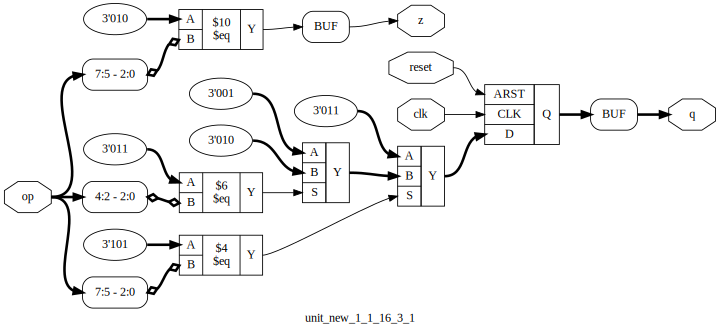

In [16]:
from ys_aux import to_svg
display(to_svg(design))

### Comparison

Let's see if it turns out to be the same result as the 'legacy' implementation from `unit`:

SYNTHESIS: Wrapping for inference: MyImpl()
Implementation: Test implementation
SYNTHESIS: Implementing unit 'rtl'
CREATE Module: 'unit'
Adding module with name: unit_1_1_16_3_1
CONVERT_RTL tree >>>>>> 'UNIT_WORKER' 
CONVERT_RTL tree >>>>>> 'UNIT_ASSIGN' 
DONE instancing submodules
Generating RTL image...
Display...


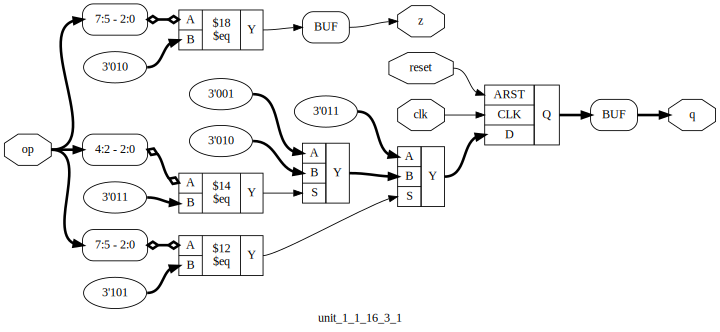

In [17]:
impl_orig = test_design(unit)
design2 = impl_orig.implement("rtl", "unit")
display(to_svg(design2))